# BGSE Text Mining Homework 2
## Euan Dowers, Veronika Kyuchukova, and Laura Roman

### Exercise 1

The objective of this exercise is to implement uncollapsed gibbs sampling for fitting an LDA model to state of the union speeches from 1945 onwards, with documents being defined at the paragraph level. 

First, we need to read in and process the data, as in the first homework set:

In [1]:
import numpy as np
import pandas as pd
import nltk
import os
import sys
import scipy.sparse as ssp
import time
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import dirichlet, multinomial
from collections import Counter
from utils import data_processing, get_vocab, make_count
%matplotlib inline

In [ ]:
import tqdm
from tqdm import tqdm

In [4]:
data = pd.read_table("data/speech_data_extend.txt",encoding="utf-8")
data_post1945 = data.loc[data.year >= 1945]
%time stemmed, processed_data = data_processing(data_post1945)

CPU times: user 8.65 s, sys: 20 ms, total: 8.67 s
Wall time: 8.67 s


Now we will create a function that implements uncollapsed gibbs sampling on our processed data.
This essentially works by repeatedly sampling from the posterior distributions of $Z$, $\Theta$, and $\beta$ and updating values using the most recent sample. 

In [3]:
def Gibbs_sampling_LDA(stemmed, K, alpha = None, eta = None, m=3, n_samples = 200, burnin = 500, perplexity = False):
    '''
    Gibbs sampler for LDA model
    '''

    def Z_sample(Beta, Theta, Theta_x_Beta):
        denom = Theta_x_Beta
        Z = [0] * len(stemmed)
        for i in range(len(stemmed)):
            sel = [idx[word] for word in stemmed[i]]
            prod = Beta[:,sel].T * Theta[i,:].reshape((1,K))
            probs = prod / denom[i,sel].reshape(len(stemmed[i]),1)
            Z[i] = [np.argmax(multinomial(n=1, pvals = z, size = 1)[0]) for z in probs]
        return Z

    def Beta_sample(eta, Z):
        z_s = [z for sublist in Z for z in sublist ]
        M = np.zeros(shape=(K,V))
        for k in range(K):
            words = [s[i] for i in range(len(z_s)) if z_s[i] == k]
            counts = Counter(words)
            for word in set(words):
                M[k,idx[word]] = counts[word]
        Beta = [dirichlet(alpha = eta + M[i],size = 1)[0] for i in range(K)]
        return np.array(Beta)

    def Theta_sample(alpha, Z):
        N   = np.zeros(shape=(D,K))
        for i in range(D):
            counts   = Counter(Z[i])
            for j in set(counts.keys()):
                N[i,j]  = counts[j]
        Theta = [dirichlet(alpha = alpha + N[i],size = 1)[0] for i in range(D)]
        return np.array(Theta)

    def perplexity(Theta_x_Beta, count_matrix):
        '''
        Calculate perplexity for given sample
        '''
        ltb     = np.log(Theta_x_Beta)
        num     = np.sum(count_matrix.multiply(ltb))
        denom   = len(s)
        return np.exp(-num/denom)

    # Get params needed for passing to sampling functions
    s       = [i for sublist in stemmed for i in sublist ]
    vocab   = get_vocab(stemmed)
    D       = len(stemmed)
    V       = len(vocab)
    idx     = dict(zip(vocab,range(len(vocab))))
    count_matrix = make_count(stemmed, idx)
    perp   = []

    # Initialise params
    if eta == None:
        eta = 200/V
    if alpha == None:
        alpha = 50/K

    Theta   = dirichlet(alpha = [alpha]*K, size = D)
    Beta    = dirichlet(alpha = [eta]*V, size = K)
    Theta_x_Beta = Theta.dot(Beta)
    Z       = Z_sample(Beta, Theta, Theta_x_Beta)
    labels  = np.zeros((n_samples, len(s)))

    # SAMPLING
    print('TIME:', time.strftime("%H:%M:%S", time.gmtime()))
    for i in tqdm(range(burnin)):
        Z       = Z_sample(Beta, Theta, Theta_x_Beta)
        Beta    = Beta_sample(eta, Z)
        Theta   = Theta_sample(alpha, Z)
        Theta_x_Beta = Theta.dot(Beta)
        if i%20 == 0:
            if perplexity:
                perp.append(perplexity(Theta_x_Beta, count_matrix))
            #print('Burnin iteration {}'.format(i))

    print('TIME:', time.strftime("%H:%M:%S", time.gmtime()))
    for i in tqdm(range(m*n_samples)):
        Z       = Z_sample(Beta, Theta, Theta_x_Beta)
        Beta    = Beta_sample(eta, Z)
        Theta   = Theta_sample(alpha, Z)
        Theta_x_Beta = Theta.dot(Beta)

        # Add every m-th sample to output
        if i%m == 0:
            Z_s = [i for sublist in Z for i in sublist ]
            j = np.int(i/m)
            labels[j, :] = Z_s
        if i%20 == 0:
            if perplexity:
                perp.append(perplexity(Theta_x_Beta, count_matrix))
            #print( "Iteration {}".format(i))

    return (labels, perp)

In [4]:
LDA_labels, perp = Gibbs_sampling_LDA(stemmed,
                                      K = 10,
                                      n_samples = 100,
                                      m = 5,
                                      perplexity=True,
                                      burnin = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

TIME: 06:39:10


  0%|          | 0/500 [00:00<?, ?it/s]

TIME: 07:30:21


100%|██████████| 500/500 [25:20<00:00,  3.50s/it]


As you can see this sampling function takes around 1h10m to complete 1500 iterations. The output is a list of perplexities (from every 20th sample) and a numpy array containing a label assignment for each word in the corpus, for each sampling iteration after the initial burnin period. Since this takes so long we have saved these outputs and will load them from disk for any further analysis. 

In [5]:
LDA_labels.tofile('data/LDA_labels.npy')
pd.DataFrame(perp).to_csv('data/perplexity_uncollapsed.csv')

Now make a function that, given a draw from the gibbs sampling, returns a document topic matrix (for use in the next exercise).

In [6]:
doc_label = [[i]*len(stemmed[i]) for i in range(len(stemmed))]
doc_label = [i for sublist in doc_label for i in sublist]

def dt_matrix(labels, doc_label):
    dt = np.zeros((len(set(doc_label)), K))
    label_dict = dict(zip(range(labels.shape[0]), labels.astype(int)))
    doc_dict = dict(zip(range(len(doc_label)), doc_label))
    for i in range(len(doc_label)):
        dt[doc_dict[i], label_dict[i]] += 1
    return dt

Now use this to come up with some kind of estimate of the predictive distribution of theta

In [28]:
alpha = 50/10
K = 10
dt_avg = np.zeros((len(stemmed), 10))
for i in np.arange(0,100, 10 ):
    dt_avg += dt_matrix(LDA_labels[i], doc_label)
dt_avg /= 10

nmz = dt_avg
nm = np.array([len(doc) for doc in stemmed]).reshape(10252,1)

theta_unc = (dt_avg + alpha) / (nm + 10 * alpha)

theta_unc = pd.DataFrame(theta_uncollapsed)
theta_unc.to_csv('data/theta_uncollapsed.csv')

Here we calculate document term matrices for a number of draws and then average them to estimate the predictive distribution of $\Theta$

### Exercise 2

The objective of this exercise is to run the collapsed Gibbs sampling version for fitting an LDA model to the same data, hyperparameters and K, and compare its predictive distribution with the one we get from uncollapes Gibbs sampling. In order to do so, we will work with a Python3 adapted version of the collapsed Gibbs sampler that can be found in https: //github.com/sekhansen/text-mining-tutorial 


#### a) Plot the perplexity across sampling iterations. Which algorithm appears to burn in faster?

In [2]:
import topicmodels

In [3]:
from utils import data_processing, get_vocab, make_count

In [4]:
os.getcwd()

'/Users/Laura/Desktop/BGSE_text_mining-master/HW2'

os.getcwd() should be ('./BGSE_text_mining-master/HW2')

In [5]:
data = pd.read_table("./data/speech_data_extend.txt",encoding="utf-8")
data_post1945 = data.loc[data.year >= 1945]
%time stemmed, processed_data = data_processing(data_post1945)

CPU times: user 13.9 s, sys: 97.3 ms, total: 14 s
Wall time: 14.1 s


In [6]:
ldaobj = topicmodels.LDA.LDAGibbs(stemmed, 10)


ldaobj.sample(0, 20, 75)

perp2 = ldaobj.perplexity()
perp_2 =  pd.DataFrame(perp2)
pd.DataFrame.to_csv(perp_2,path_or_buf='data/perplexity_collapsed.csv',index=False)

Iteration 1 of (collapsed) Gibbs sampling
Iteration 2 of (collapsed) Gibbs sampling
Iteration 3 of (collapsed) Gibbs sampling
Iteration 4 of (collapsed) Gibbs sampling
Iteration 5 of (collapsed) Gibbs sampling
Iteration 6 of (collapsed) Gibbs sampling
Iteration 7 of (collapsed) Gibbs sampling
Iteration 8 of (collapsed) Gibbs sampling
Iteration 9 of (collapsed) Gibbs sampling
Iteration 10 of (collapsed) Gibbs sampling
Iteration 11 of (collapsed) Gibbs sampling
Iteration 12 of (collapsed) Gibbs sampling
Iteration 13 of (collapsed) Gibbs sampling
Iteration 14 of (collapsed) Gibbs sampling
Iteration 15 of (collapsed) Gibbs sampling
Iteration 16 of (collapsed) Gibbs sampling
Iteration 17 of (collapsed) Gibbs sampling
Iteration 18 of (collapsed) Gibbs sampling
Iteration 19 of (collapsed) Gibbs sampling
Iteration 20 of (collapsed) Gibbs sampling
Iteration 21 of (collapsed) Gibbs sampling
Iteration 22 of (collapsed) Gibbs sampling
Iteration 23 of (collapsed) Gibbs sampling
Iteration 24 of (col

Import perplexity computed with uncollapsed Gibbs sampler:

In [7]:
perp1 = pd.read_csv('data/perplexity_uncollapsed.csv') 
perp1 = np.array(perp1)
perp1 = perp1[:,1]

And compare the results by plotting the perplexity obtained with each algorithm against the samples taken:

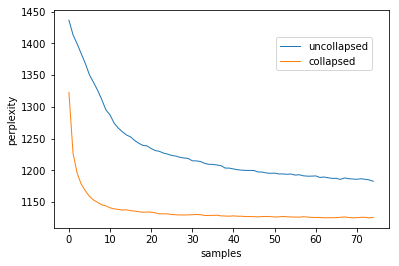

In [8]:
plt.plot(perp1,   lw = 1., label = 'uncollapsed')
plt.plot(perp2, lw = 1., label = 'collapsed')
plt.legend(loc='center left', bbox_to_anchor=(0.65, 0.8))
plt.ylabel('perplexity')
plt.xlabel('samples')
plt.savefig('figures/perplexities.png', bbox_inches='tight')

We can see that while the collapsed Gibbs sampler stabilizes rapidly, at 10 samples  and with a perplexity of 1130 more or less, the uncollapsed Gibbs sampler seems not to fully stabilize with even more than 75 samples.

#### b) After the burn-in period, construct estimates of the predictive distribution of theta for each document across a number of draws from the samplers. Are the average values of these predictive distributions similar in the uncollapsed and collapsed samplers? How variable are these predictive distributions in the two algorithms across sample draws?

In [ ]:
ldaobj = topicmodels.LDA.LDAGibbs(stemmed, 10)
ldaobj.sample(1000, 5, 100)


Iteration 1 of (collapsed) Gibbs sampling
Iteration 2 of (collapsed) Gibbs sampling
Iteration 3 of (collapsed) Gibbs sampling
Iteration 4 of (collapsed) Gibbs sampling
Iteration 5 of (collapsed) Gibbs sampling
Iteration 6 of (collapsed) Gibbs sampling
Iteration 7 of (collapsed) Gibbs sampling
Iteration 8 of (collapsed) Gibbs sampling
Iteration 9 of (collapsed) Gibbs sampling
Iteration 10 of (collapsed) Gibbs sampling
Iteration 11 of (collapsed) Gibbs sampling
Iteration 12 of (collapsed) Gibbs sampling
Iteration 13 of (collapsed) Gibbs sampling
Iteration 14 of (collapsed) Gibbs sampling
Iteration 15 of (collapsed) Gibbs sampling
Iteration 16 of (collapsed) Gibbs sampling
Iteration 17 of (collapsed) Gibbs sampling
Iteration 18 of (collapsed) Gibbs sampling
Iteration 19 of (collapsed) Gibbs sampling
Iteration 20 of (collapsed) Gibbs sampling
Iteration 21 of (collapsed) Gibbs sampling
Iteration 22 of (collapsed) Gibbs sampling
Iteration 23 of (collapsed) Gibbs sampling
Iteration 24 of (col

In [22]:
k = ldaobj.K
alpha =  ldaobj.alpha
docterms = ldaobj.dt_avg()
nm = np.array([len(doc) for doc in stemmed])
nm = nm.reshape((10252,1))
nmz = nm*docterms

theta_collapsed = (nmz+alpha)/(nm+k*alpha)
theta_collapsed =  pd.DataFrame(theta_collapsed)
pd.DataFrame.to_csv(theta_collapsed,path_or_buf='data/theta_collapsed.csv',index=False)


theta_uncoll = pd.read_csv('data/theta_uncollapsed.csv') 
theta_uncoll.drop( 'Unnamed: 0',axis=1,inplace=True)
theta_uncoll = np.array(theta_uncoll)

We now proced to compare the average value of the predictive distributions in the uncollapsed and collapsed samplers. Also, we take a step more and compute the standard deviation and variance. 

In [23]:
theta_collapsed.mean()
theta_uncoll.mean()

# from collapsed gibbs sampler
m_c = np.array(theta_collapsed.mean(axis=0))
st_c= np.array(theta_collapsed.std(axis=0))
var_c = np.array(np.var(theta_collapsed, axis=0))

# from uncollapsed gibbs sampler
m_u = np.array(theta_uncoll.mean(axis=0))
st_u = np.array(theta_uncoll.std(axis=0))
var_u = np.array(np.var(theta_uncoll, axis=0))

basic_stats = pd.DataFrame(np.vstack((m_c,m_u,st_c,st_u,var_c,var_u)).T)
basic_stats.columns = ['mean_c','mean_unc','sd_c','sd_unc','var_c','var_u']
basic_stats

,mean_c,mean_unc,sd_c,sd_unc,var_c,var_u
0,0.100011,0.099276,0.015909,0.033119,0.000253,0.001097
1,0.100777,0.099498,0.019660,0.037753,0.000386,0.001425
2,0.099052,0.098141,0.011505,0.032473,0.000132,0.001055
3,0.099434,0.100644,0.012210,0.040438,0.000149,0.001635
4,0.099843,0.101699,0.015265,0.046831,0.000233,0.002193
5,0.100023,0.099611,0.016726,0.031970,0.000280,0.001022
6,0.100122,0.100642,0.020249,0.037369,0.000410,0.001396
7,0.100338,0.099281,0.017831,0.032323,0.000318,0.001045
8,0.100667,0.100500,0.019628,0.045579,0.000385,0.002077
9,0.099734,0.100710,0.014273,0.035376,0.000204,0.001251


A few observations from these results are:
- The average value of the predictive distribution with the uncollapsed and collapsed gibbs samplers for each of the 10 topics are very similar, as well as the mean of the distribution which is 0.0999999 for both cases.
- The standard deviation across topics and for each model is rather different, being bigger for the uncollapsed sampler. 
- The variance is significantly much smaller for each topic when working with the collapsed gibbs sampler than with the uncollapsed sampler indicating that the predictive distributions for for the collapsed case are more peaked and thin.

Indeed, we can see such difference in the width of topic distributions for each sampler:

- Collapsed gibbs sampler predictive distributions:

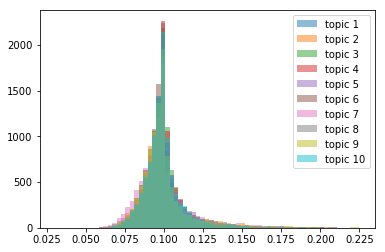

In [29]:
# collapsed gibbs sampler
theta_collapsed = np.array(theta_collapsed)


t1 = theta_collapsed[:,0]
t2 = theta_collapsed[:,1]
t3 = theta_collapsed[:,2]
t4 = theta_collapsed[:,3]
t5 = theta_collapsed[:,4]
t6 = theta_collapsed[:,5]
t7 = theta_collapsed[:,6]
t8 = theta_collapsed[:,7]
t9 = theta_collapsed[:,8]
t10 = theta_collapsed[:,9]

bins = np.linspace(0.03, 0.225, 70)

plt.hist(t1, bins, alpha=0.5, label='topic 1')
plt.hist(t2, bins, alpha=0.5, label='topic 2')
plt.hist(t3, bins, alpha=0.5, label='topic 3')
plt.hist(t4, bins, alpha=0.5, label='topic 4')
plt.hist(t5, bins, alpha=0.5, label='topic 5')
plt.hist(t6, bins, alpha=0.5, label='topic 6')
plt.hist(t7, bins, alpha=0.5, label='topic 7')
plt.hist(t8, bins, alpha=0.5, label='topic 8')
plt.hist(t9, bins, alpha=0.5, label='topic 9')
plt.hist(t10, bins, alpha=0.5, label='topic 10')

plt.legend(loc='upper right')
plt.show()
plt.savefig('figures/collapsed_distrib.png', bbox_inches='tight')

- Uncollapsed gibbs sampler predictive distributions:

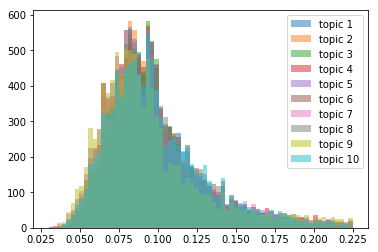

In [30]:
# uncollapsed gibbs sampler

ut1 = theta_uncoll[:,0]
ut2 = theta_uncoll[:,1]
ut3 = theta_uncoll[:,2]
ut4 = theta_uncoll[:,3]
ut5 = theta_uncoll[:,4]
ut6 = theta_uncoll[:,5]
ut7 = theta_uncoll[:,6]
ut8 = theta_uncoll[:,7]
ut9 = theta_uncoll[:,8]
ut10 = theta_uncoll[:,9]

bins = np.linspace(0.03, 0.225, 70)

plt.hist(ut1, bins, alpha=0.5, label='topic 1')
plt.hist(ut2, bins, alpha=0.5, label='topic 2')
plt.hist(ut3, bins, alpha=0.5, label='topic 3')
plt.hist(ut4, bins, alpha=0.5, label='topic 4')
plt.hist(ut5, bins, alpha=0.5, label='topic 5')
plt.hist(ut6, bins, alpha=0.5, label='topic 6')
plt.hist(ut7, bins, alpha=0.5, label='topic 7')
plt.hist(ut8, bins, alpha=0.5, label='topic 8')
plt.hist(ut9, bins, alpha=0.5, label='topic 9')
plt.hist(ut10, bins, alpha=0.5, label='topic 10')

plt.legend(loc='upper right')
plt.show()
plt.savefig('figures/uncoll_distrib.png', bbox_inches='tight')

### Exercise 3

In this exercise we are interested in comparing the classification performance of a penalized logistic regression when paragraphs (which is associated with one of two political parties) are represented as unigram counts over raw terms versus topic shares. We use training samples to estimate the relationship between document content and political party, and then assess its out-of-sample performance on held-out data.

First we need to create a `party` variable and create a count matrix, then we can fit our models. 

In [3]:
pres = ['BushI', 'BushII', 'Carter', 'Clinton', 'Eisenhower', 'Ford', 'JohnsonII', 'Kennedy', 'Nixon', 'Obama', 'Reagan', 'RooseveltII', 'Truman']
party = ['R','R','D','D','R','R','D','D','R','D','R','D','D']
pres_party = dict(zip(pres, party))

# check party assignments are correct
print(pres_party)

{'Nixon': 'R', 'Carter': 'D', 'Reagan': 'R', 'JohnsonII': 'D', 'Kennedy': 'D', 'BushII': 'R', 'Clinton': 'D', 'RooseveltII': 'D', 'Truman': 'D', 'Eisenhower': 'R', 'Obama': 'D', 'BushI': 'R', 'Ford': 'R'}


In [5]:
parties = [pres_party[i] for i in processed_data.president]

vocab   = get_vocab(stemmed)
D       = len(stemmed)
V       = len(vocab)
idx     = dict(zip(vocab,range(len(vocab))))

X = make_count(stemmed, idx).toarray() # make_count was a sparse array, so transfrom to np.array

In [8]:
###############
# LASSO
###############

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, parties)

model = LogisticRegression(penalty = 'l1')

model.fit(X_train, y_train)
preds = model.predict(X_test)

In [10]:
print(accuracy_score(y_test, preds))
print(confusion_matrix(y_test, preds)) 

0.691767460008
[[1206  330]
 [ 460  567]]


In [11]:
######################
# Ridge
######################

model = LogisticRegression(penalty = 'l2')
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [12]:
print(accuracy_score(y_test, preds))
print(confusion_matrix(y_test, preds)) 

0.699570815451
[[1215  321]
 [ 449  578]]


Now use topic assignments

In [16]:
###########################
# Using topic assignments
###########################
from lda import LDA

lda_labels = LDA(n_topics = 20)
lda_labels.fit(X)
dt = lda_labels.doc_topic_

X_train, X_test, y_train, y_test = train_test_split(dt, parties)

INFO:lda:n_documents: 10252
INFO:lda:vocab_size: 8491
INFO:lda:n_words: 298225
INFO:lda:n_topics: 20
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -3545641
INFO:lda:<10> log likelihood: -2574790
INFO:lda:<20> log likelihood: -2453290
INFO:lda:<30> log likelihood: -2409415
INFO:lda:<40> log likelihood: -2387055
INFO:lda:<50> log likelihood: -2369930
INFO:lda:<60> log likelihood: -2360482
INFO:lda:<70> log likelihood: -2353386
INFO:lda:<80> log likelihood: -2346667
INFO:lda:<90> log likelihood: -2342861
INFO:lda:<100> log likelihood: -2339912
INFO:lda:<110> log likelihood: -2335970
INFO:lda:<120> log likelihood: -2334715
INFO:lda:<130> log likelihood: -2332293
INFO:lda:<140> log likelihood: -2331748
INFO:lda:<150> log likelihood: -2329259
INFO:lda:<160> log likelihood: -2326872
INFO:lda:<170> log likelihood: -2326207
INFO:lda:<180> log likelihood: -2325881
INFO:lda:<190> log likelihood: -2326123
INFO:lda:<200> log likelihood: -2324020
INFO:lda:<210> log likelihood: -2323670
INFO:lda

In [17]:
model = LogisticRegression(penalty = 'l1')
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(accuracy_score(y_test, preds))

0.602028872415


In [18]:
model = LogisticRegression(penalty = 'l2')
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(accuracy_score(y_test, preds))

0.602809207959


Interestingly, using topic assignments is significantly worse than using raw term-counts